# Hello Object Detection

A very basic introduction to using object detection models with OpenVINO™.

The [horizontal-text-detection-0001](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/horizontal-text-detection-0001/README.md) model from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. It detects horizontal text in images and returns a blob of data in the shape of `[100, 5]`. Each detected text box is stored in the `[x_min, y_min, x_max, y_max, conf]` format, where the
`(x_min, y_min)` are the coordinates of the top left bounding box corner, `(x_max, y_max)` are the coordinates of the bottom right bounding box corner and `conf` is the confidence for the predicted class.


#### Table of contents:

- [Imports](#Imports)
- [Download model weights](#Download-model-weights)
- [Select inference device](#Select-inference-device)
- [Load the Model](#Load-the-Model)
- [Load an Image](#Load-an-Image)
- [Do Inference](#Do-Inference)
- [Visualize Results](#Visualize-Results)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/hello-detection/hello-detection.ipynb" />


## Imports
[back to top ⬆️](#Table-of-contents:)


In [4]:
import openvino as ov
import cv2
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

## Available inference device
select device from dropdown list for running inference using OpenVINO

In [5]:
core = ov.Core()
options = core.available_devices
options

['CPU', 'GPU']

In [8]:
# load the model

model = core.read_model(model='./model/horizontal-text-detection-0001.xml')
compiled_model = core.compile_model(model=model, device_name='CPU')

input_layer = compiled_model.input(0)
output_layer = compiled_model.output("boxes")

print(input_layer.shape)

[1,3,704,704]


(704, 704, 3)


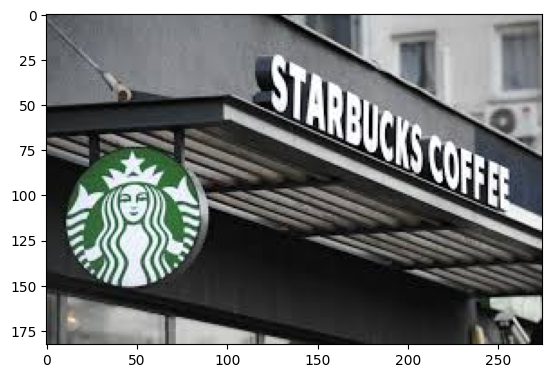

In [14]:
# load an Image

# Text detection models expect an image in BGR format.
image = cv2.imread(str('./data/starbucks.jpg'))

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))
print(resized_image.shape)

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Do Inference
[back to top ⬆️](#Table-of-contents:)


In [15]:
# Create an inference request.
boxes = compiled_model([input_image])[output_layer]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

print(boxes)

[[2.9888489e+02 7.9378998e+01 5.5426947e+02 3.5385312e+02 5.2945900e-01]
 [5.3673889e+02 2.4664877e+02 6.6681964e+02 4.3342715e+02 4.3885216e-01]]


## Visualize Results
[back to top ⬆️](#Table-of-contents:)


In [16]:
# For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format:
# The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],  # 517, 690
        resized_image.shape[:2],  # 704, 704
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

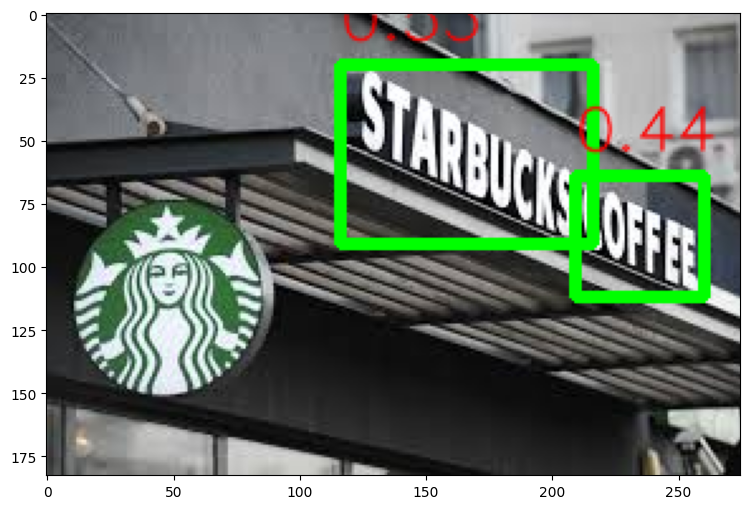

In [19]:
plt.figure(figsize=(10, 6))
plt.axis("on")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=True));

## 6. 배포

In [20]:
import openvino as ov
import cv2
import numpy as np

from pathlib import Path
import PIL
import gradio as gr

In [21]:
core = ov.Core()
options = core.available_devices
options

['CPU', 'GPU']

In [22]:
model = core.read_model(model='model/horizontal-text-detection-0001.xml')
compiled_model = core.compile_model(model=model, device_name="GPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output("boxes")

In [24]:
def preprocess(image):
    # Convert the PIL image to a NumPy array and resize to 224x224
    image = np.array(image)  # Convert PIL image to numpy array
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

    N, C, H, W = input_layer.shape
    resized_image = cv2.resize(image, (W, H))
    input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
    
    return input_image, resized_image

In [25]:
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],       # 517, 690
        resized_image.shape[:2],   #704, 704
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

In [27]:
def predict_image(image):
    input_image, resized_image = preprocess(image)  # Preprocess the image
    boxes = compiled_model([input_image])[output_layer]  # Perform inference
    boxes = boxes[~np.all(boxes == 0, axis = 1)]
    canvas = convert_result_to_image(image, resized_image, boxes, conf_labels = True)
    return canvas

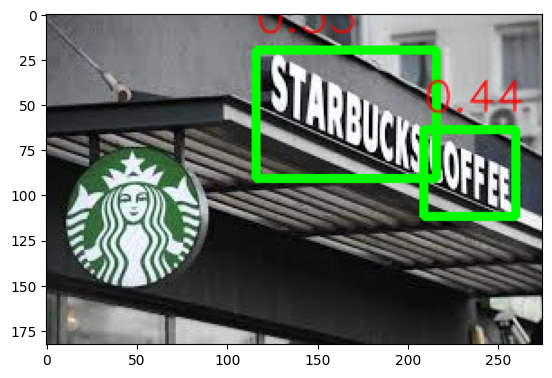

In [30]:
image = cv2.imread('./data/starbucks.jpg')
predict_image(image)
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=True));

In [31]:
demo = gr.Interface(predict_image, gr.Image(), "image")
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
